# Dubinska analiza podataka - projektni zadatak

## 1. Predprocesiranje podataka

In [1]:
library(tidyr)
library(dplyr)
library(neuralnet)
library(caret)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'neuralnet'


The following object is masked from 'package:dplyr':

    compute


Loading required package: ggplot2

Loading required package: lattice



In [19]:
phoneData <- read.csv('phone_specs.csv')

#str(phoneData)

In [3]:
table(phoneData$OS)


   Android BlackBerry   Cyanogen        iOS   Sailfish      Tizen    Windows 
      1299         10         10         17          1          3         19 

In [20]:
phoneData <- phoneData %>%
    filter(!(OS == 'Sailfish' | OS == 'Tizen' |
            OS == 'Cyanogen' | OS == 'BlackBerry')) %>%                       # delete rows with less know OS (only 24 rows)
    mutate(across(c(Touchscreen, WiFi, Bluetooth, GPS, X3G, X4G.LTE),
          ~as.numeric(ifelse(.x == 'Yes', 1, 0)))) %>%                        # convert categorical Yes/No to 1/0
    mutate(value = 1) %>% spread(OS, value,  fill = 0 ) %>%                   # One-hot-encoding OS column
    mutate(across(c(5,6, 8:14, 18), scale)) %>%                               # normalization with scale() for numeric data
    mutate(Price=round(Price/87.95)) %>%                                      # convert indian rupee to euro
    mutate(PriceCategory = ifelse(Price <= 200, '200',
                           ifelse(Price <= 500, '500', '>500')))

In [21]:
phoneData <- phoneData[ -c(1:4,21) ]

In [22]:
table(phoneData$PriceCategory)


>500  200  500 
  49 1145  141 

## 2. Klasifikacija - umjetne neuronske mreže

In [32]:
set.seed(123)
indeksi = createDataPartition(phoneData$PriceCategory, p = 0.8, list = FALSE)
skup_tren <- phoneData[indeksi, ]
skup_test <- phoneData[-indeksi, ] 

nn = neuralnet(PriceCategory ~ .,
                data = skup_tren,
                hidden = c(10,5),
                lifesign = 'full',
                linear.output = FALSE,
                stepmax = 1000000)

hidden: 10, 5    thresh: 0.01    rep: 1/1    steps: 
   1000	min thresh: 0.241610062112271
                                                    
   2000	min thresh: 0.167603747600562
                                                    
   3000	min thresh: 0.090319064554554
                                                    
   4000	min thresh: 0.049605901700861
                                                    
   5000	min thresh: 0.0321378429946221
                                                    
   6000	min thresh: 0.0207490459549198
                                                    
   7000	min thresh: 0.0162028464514437
                                                    
   8000	min thresh: 0.0134453064850204
                                                    
   9000	min thresh: 0.0105121571629427
                                                    
   9526
	error: 32.17918
	time: 45.8 secs



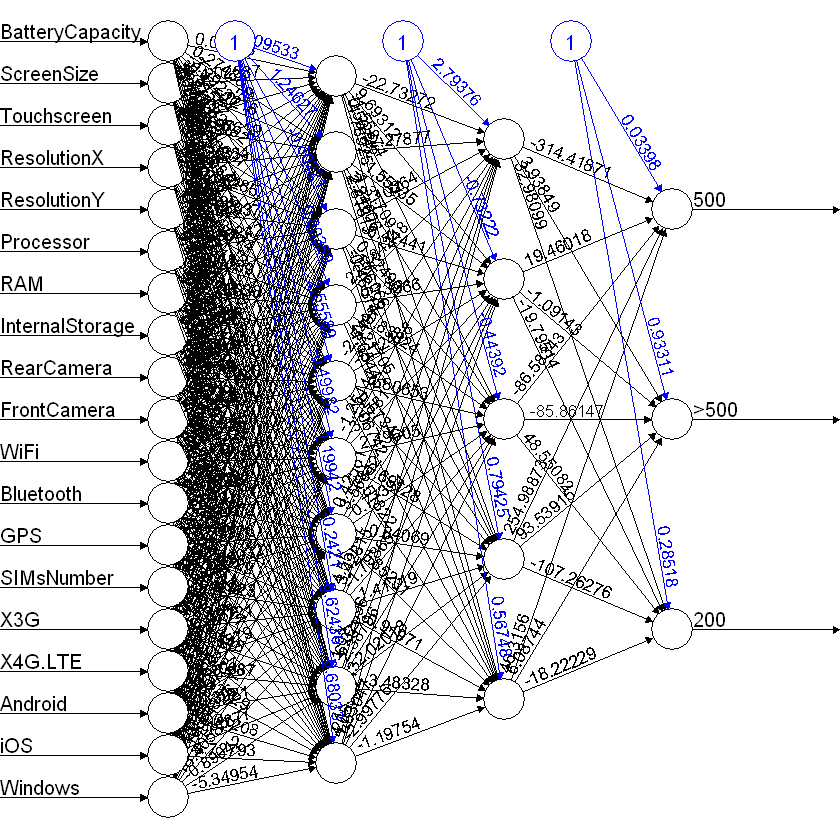

In [33]:
plot(nn, rep=1)

In [34]:
predikcije <- neuralnet::compute(nn, rep = 1, skup_test[,-20])

pred <- predikcije$net.result

pred <- data.frame("pred"=ifelse(max.col(pred[ ,1:3])==1, ">500",
                          ifelse(max.col(pred[ ,1:3])==2, "200", "500")))

cm <- confusionMatrix(as.factor(skup_test$PriceCategory), as.factor(pred$pred))
 
print(cm)

Confusion Matrix and Statistics

          Reference
Prediction >500 200 500
      >500    5   2   2
      200     1 221   7
      500     2  16  10

Overall Statistics
                                          
               Accuracy : 0.8872          
                 95% CI : (0.8429, 0.9226)
    No Information Rate : 0.8985          
    P-Value [Acc > NIR] : 0.7655          
                                          
                  Kappa : 0.4825          
                                          
 Mcnemar's Test P-Value : 0.2775          

Statistics by Class:

                     Class: >500 Class: 200 Class: 500
Sensitivity              0.62500     0.9247    0.52632
Specificity              0.98450     0.7037    0.92713
Pos Pred Value           0.55556     0.9651    0.35714
Neg Pred Value           0.98833     0.5135    0.96218
Prevalence               0.03008     0.8985    0.07143
Detection Rate           0.01880     0.8308    0.03759
Detection Prevalence     0.03383    

## 3. Ansambli - slučajne šume

## 4. Asocijacijska analiza - učenje asocijacijskih pravila

## 5. Grupiranje k-sredina